# Bayesian Networks and Flight Delay : SFO to PHL

Flight delay is a costly problem to consumers, airlines, and industrial experts. Delays provoke complaints from passengers, create high costs to airlines, and result in difficulties for airport operations. It is therefore important for the Federal Aviation Administration (FAA) to understand the causes of delay as a means to reduce the total cost that delays can cause.

Known factors that cause flight delays include weather at the origin airport, congestion at the origin airport, and air traffic management (ATM) decisions such as Ground Delay Programs (GDP). Each component interacts with other components in complex ways, which is why flight delays are an inherently stochastic phenomenon. Simply examining the marginal distributions of such factor does not truly reveal the effects that such factors have or the relationship between any two of such factors.

Here, we will perform a case study of the use of Bayesian networks to model the relationship between different components of aircraft delay and the causal factors that affect delays. Bayesian networks allow us to simultaneously examine multiple components of delay and their relationships in a single analysis, an advantage that the use of Bayesian networks has over linear and nonlinear regression models. Moreover, Bayesian network models provide not only just predictions of future delays that incorporate the interrelationships among causal factors, but also a means of assessing the ultimate influence each causal factors has on arrival delay.

In particular, we will examine delays in flight from San Francisco International Airport (SFO) to Philadelphia International Airport (PHL).

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import time
import calendar
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
def filterRoutes(df):
    '''
    filter df to contain delayed fligths from SFO to PHL routes only.
    '''
    df = df[(df['ORIGIN'] == 'SFO') & (df['DEST'] == 'PHL') & (df['ARR_DELAY'] > 0)]
    df = df.reset_index()
    return df.drop(['index','YEAR','ORIGIN','DEST', 'UNIQUE_CARRIER','DEP_TIME','DEP_TIME_BLK','DEP_DELAY_GROUP', 'DEP_DELAY_NEW', 'DEP_DEL15','WHEELS_OFF','WHEELS_ON','ARR_DELAY','ARR_DELAY_NEW','DIVERTED','Unnamed: 29'],axis=1)

def dateColumns(df):
    '''
    Given a column with mm/dd/yyyy, create a MONTH and DAY column.
    '''
    dates = [str(d).replace('/','') for d in list(df['Date'])]
    dates = [time.strptime(d,'%m%d%Y') for d in dates]
    df['MONTH'] = [d.tm_mon for d in dates]
    df['DAY'] = [d.tm_mday for d in dates]
    
def changeTimetoBinary(df, col):
    '''
    change all times in df[col] to binary variable AM (0) or PM (1)
    '''
    mask = df[col] < 12.0
    df.loc[mask, col] = 0
    mask = df[col] >= 12.0
    df.loc[mask, col] = 1

## The Nitty-Gritty: Preparing the Data

### Read and Merge

We are working with two datasets. The first is provided by the Bureau of Transportation Statistics and contains flight information, including Common Reporting Standard (CRS) arrival and departure times, causes of delay, and time spend taxiing in and out. We will start by reading in twelve months' worth of data and filtering for just the SFO to PHL routes.

In [3]:
# read data and filter for relevant delayed flights
jan_df = filterRoutes(pd.read_csv('./month/jan2017.csv'))
feb_df = filterRoutes(pd.read_csv('./month/feb2017.csv'))
mar_df = filterRoutes(pd.read_csv('./month/mar2017.csv'))
apr_df = filterRoutes(pd.read_csv('./month/apr2017.csv'))
may_df = filterRoutes(pd.read_csv('./month/may2017.csv'))
jun_df = filterRoutes(pd.read_csv('./month/jun2017.csv'))
jul_df = filterRoutes(pd.read_csv('./month/jul2017.csv'))
aug_df = filterRoutes(pd.read_csv('./month/aug2017.csv'))
sep_df = filterRoutes(pd.read_csv('./month/sep2017.csv'))
oct_df = filterRoutes(pd.read_csv('./month/oct2017.csv'))
nov_df = filterRoutes(pd.read_csv('./month/nov2017.csv'))
dec_df = filterRoutes(pd.read_csv('./month/dec2017.csv'))

# concatenate dataframes by quarter
flights_df = pd.concat([jan_df, feb_df,mar_df,apr_df, may_df, jun_df, jul_df, aug_df, sep_df, oct_df, nov_df, dec_df])

# keep hour information from CRS but not minutes
flights_df['CRS_DEP_TIME'] = flights_df['CRS_DEP_TIME'] // 100
flights_df['CRS_ARR_TIME'] = flights_df['CRS_ARR_TIME'] // 100

Secondly, we will read in the data provided by the Federal Aviation Administration (FAA) on airport situations in SFO and PHL in 2017 in 'ASPM : Airport Analysis : Delayed Flights Report.' After reading in the data, we will merge the two dataframes to create one flights_df dataframe.

In [4]:
airports_df = pd.read_csv('./faa-aspm/airports.csv').dropna(axis=0,how='all')

# split Date into MONTH and DAY
airports_df['Facility'] = airports_df['Facility'].str.strip()
dateColumns(airports_df)
airports_df = airports_df.drop(['Date','% DelayedGateDepartures','% DelayedGateArrivals','Date'],axis=1)
airports_df = airports_df.drop(['DeparturesFor MetricComputation','ArrivalsFor MetricComputation','AverageMinutesOf DelayPer DelayedGateDeparture','AverageMinutesOf DelayPer DelayedGateArrival'],axis=1)

# find departure and arrival informations at airport at time of departure/arrival
# SFO (departure)
flights_SFO_df = pd.merge(flights_df, airports_df, how='inner', left_on=['MONTH','DAY_OF_MONTH','CRS_DEP_TIME'], right_on=['MONTH','DAY','Hour'])
flights_SFO_df = flights_SFO_df[flights_SFO_df['Facility'] == 'SFO']
# PHL (arrival)
flights_PHL_df = pd.merge(flights_df, airports_df, how='inner', left_on=['MONTH','DAY_OF_MONTH','CRS_DEP_TIME'], right_on=['MONTH','DAY','Hour'])
flights_PHL_df = flights_PHL_df[flights_PHL_df['Facility'] == 'PHL']
# set departure/arrival information as fields of flights_df
flights_df['DelayedDepartureSFO'] = flights_PHL_df['DelayedGateDepartures']
flights_df['ScheduledDepartureSFO'] = flights_PHL_df['ScheduledDepartures']
flights_df['DelayedArrivalPHL'] = flights_PHL_df['DelayedGateArrivals']
flights_df['ScheduledArrivalPHL'] = flights_PHL_df['ScheduledArrivals']
flights_df.fillna(0,inplace=True)
flights_df = flights_df.reset_index()
flights_df = flights_df.drop(['index'],axis=1)

In [5]:
# change all times to binary variable AM (0) or PM (1)
changeTimetoBinary(flights_df, 'CRS_DEP_TIME')
changeTimetoBinary(flights_df, 'CRS_ARR_TIME')

We no longer need information about DAY_OF_MONTH, so we will drop that column. The compiled data is as below. Due to the length of each field name, we transpose the dataframe for readability.

In [6]:
flights_df = flights_df.drop(['DAY_OF_MONTH'],axis=1)
# save as CSV
flights_df.to_csv('full_data.csv',index=False)
flights_df.transpose()

,0,1,2,3,4,5,6,7,8,9,...,958,959,960,961,962,963,964,965,966,967
QUARTER,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
MONTH,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0
DAY_OF_WEEK,3.0,6.0,4.0,6.0,7.0,1.0,2.0,4.0,5.0,4.0,...,4.0,4.0,3.0,2.0,1.0,2.0,1.0,7.0,5.0,4.0
CRS_DEP_TIME,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
DEP_DELAY,28.0,90.0,32.0,24.0,-1.0,0.0,-9.0,17.0,2.0,1.0,...,81.0,23.0,-1.0,-6.0,14.0,10.0,-5.0,0.0,35.0,0.0
TAXI_OUT,26.0,12.0,17.0,16.0,29.0,16.0,19.0,24.0,23.0,31.0,...,20.0,29.0,39.0,36.0,45.0,21.0,29.0,27.0,29.0,27.0
TAXI_IN,3.0,5.0,4.0,6.0,4.0,6.0,5.0,3.0,3.0,7.0,...,5.0,6.0,5.0,5.0,8.0,11.0,11.0,7.0,10.0,5.0
CRS_ARR_TIME,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0
ARR_DEL15,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
CARRIER_DELAY,0.0,30.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,1.0,...,5.0,20.0,0.0,0.0,14.0,0.0,0.0,0.0,35.0,0.0


### Train and Test Data

Let the five delay causes (CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY) and the variable we are looking to explain (ARR_DEL15) be nodes. We must perform regression analysis to determine dependency relationships.

In [7]:
# 20% test data
from sklearn.model_selection import train_test_split
# 774 train data, 194 test data
train_df,test_df = train_test_split(flights_df, test_size=0.2)
# save as CSV
train_df.to_csv('train_data.csv',index=False)
test_df.to_csv('test_data.csv',index=False)

## Finding Dependencies: Regression Analysis

We use the Ordinary Least Squares (OLS) method to find dependencies, starting with what we know to be the final outcome: ARR_DEL15 (which is 0 if the flight does not arrive more than 15 minutes late, 1 otherwise). As we find dependencies, we will also be making sure that we are not creating any accidental cycles.

In [8]:
bn = nx.DiGraph()
flight_edges_df = pd.DataFrame(columns=['from_node', 'to_node'])

In [9]:
def regression_model(from_li, to_node):
    '''
    return OLS regression model, given list from_li of nodes and singular to_node
    '''
    X = train_df[from_li]
    y = train_df[to_node]
    model = sm.OLS(y, X).fit()
    return model

def update_flights_edges_df(from_li, str_var, flight_edges_df):
    '''
    update dataframe of edges using a list of from nodes, the string value of the node,
    and the current dataframe of edges.
    '''
    # update flights_edges_df with from_node to to_node entries
    flights_edges_dict = dict()
    for node in from_li:
        flights_edges_dict[node] = str_var
    temp_df = pd.DataFrame(list(flights_edges_dict.items()), columns=['from_node', 'to_node'])
    flight_edges_df = pd.concat([flight_edges_df, temp_df]).reset_index()
    flight_edges_df = flight_edges_df.drop(['index'], axis=1)

    # create network
    bn = nx.from_pandas_edgelist(flight_edges_df,source='from_node',target='to_node',create_using=nx.DiGraph())
    
    # check to see if there are cycles, print one cycle if there exists at least one
    try:
        print(nx.find_cycle(bn, source=None, orientation='original'))
    except:
        print('No cycle found! You may proceed.')
        
    return flight_edges_df, bn

def draw_graph(df,name):
    '''
    takes in dataframe of edges (from_node, to_node) and plots directed graph
    saves to name
    '''
    # create network
    G = nx.from_pandas_edgelist(df,source='from_node',target='to_node',create_using=nx.DiGraph())

    G_edges = [edge for edge in G.edges()]
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), node_size = 200,alpha=0.3)
    nx.draw_networkx_labels(G, pos,font_size='10')
    nx.draw_networkx_edges(G, pos, edgelist=G_edges, edge_color='b',style='dot', arrows=True,arrow_size = 15,alpha=0.5)
    plt.savefig('./images/'+ name)
    plt.show()
    
def remove_edge(from_edge,to_edge,df):
    '''
    remove from_edge to to_edge directed edge from df
    '''
    # remove edge from df
    df = df[(flight_edges_df.from_node != from_edge) | (flight_edges_df.to_node != to_edge)]
    
    # create network
    G = nx.from_pandas_edgelist(df,source='from_node',target='to_node',create_using=nx.DiGraph())
    # check for cycles
    try:
        print(nx.find_cycle(G, source=None, orientation='original'))
    except:
        print('No cycle found! You may proceed.')
    return df, G

### ARR_DEL15

In [10]:
arr_15_from = ['CRS_DEP_TIME','DEP_DELAY','CRS_ARR_TIME','CARRIER_DELAY','NAS_DELAY','LATE_AIRCRAFT_DELAY']
regression_model(arr_15_from, 'ARR_DEL15').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              ARR_DEL15   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     296.4
Date:                Sun, 08 Apr 2018   Prob (F-statistic):          4.41e-196
Time:                        03:49:14   Log-Likelihood:                -387.49
No. Observations:                 774   AIC:                             787.0
Df Residuals:                     768   BIC:                             814.9
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
CRS_DEP_TIME            0.3828      0.023     16.297      0.000       0.337       0.429
DEP_DELAY              -0.0033      0.001     -3.768      0.000      -0.005      -0.002
CRS_ARR_TIME            0.2665      0.021     12.916      0.000       0.226       0.307
CARRIER_DELAY           0.0062      0.001      6.393      0.000       0.004       0.008
NAS_DELAY               0.0132      0.001     16.312      0.000       0.012       0.015
LATE_AIRCRAFT_DELAY     0.0109      0.001      8.997      0.000       0.008       0.013
==============================================================================
Omnibus:                       10.320   Durbin-Watson:                   2.129
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               11.150
Skew:                          -0.220   Prob(JB):                      0.00379
Kurtosis:                       3.390   Cond. No.                         102.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

No cycle found! You may proceed.


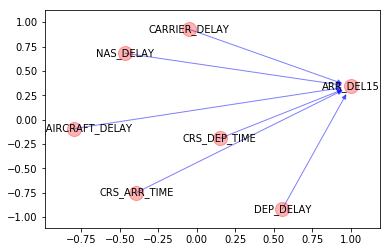

In [11]:
# update dataframe of edges and draw graph
flight_edges_df, bn = update_flights_edges_df(arr_15_from, 'ARR_DEL15',flight_edges_df)
draw_graph(flight_edges_df,'initial_bn.png')

Using regressional analysis, we conclude that ARR_DEL15 is dependent on six factors. So far, we do not have any cycles (remember that a Bayesian network consists of a directed acyclic graph), so we may proceed by moving onto finding more dependencies by choosing an arbitrary parent of ARR_DEL15.

### NAS Delay

Carrier Delay depends on

In [12]:
nas_delay_from = ['QUARTER','CRS_DEP_TIME','DEP_DELAY','TAXI_OUT','TAXI_IN','CRS_ARR_TIME','CARRIER_DELAY','WEATHER_DELAY','LATE_AIRCRAFT_DELAY']
regression_model(nas_delay_from, 'NAS_DELAY').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              NAS_DELAY   R-squared:                       0.627
Model:                            OLS   Adj. R-squared:                  0.623
Method:                 Least Squares   F-statistic:                     143.0
Date:                Sun, 08 Apr 2018   Prob (F-statistic):          2.54e-157
Time:                        03:49:15   Log-Likelihood:                -3103.6
No. Observations:                 774   AIC:                             6225.
Df Residuals:                     765   BIC:                             6267.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
QUARTER                -2.9092      0.416     -6.991      0.000      -3.726      -2.092
CRS_DEP_TIME          -11.8073      1.348     -8.761      0.000     -14.453      -9.162
DEP_DELAY               0.6460      0.028     23.246      0.000       0.591       0.701
TAXI_OUT                0.7346      0.040     18.162      0.000       0.655       0.814
TAXI_IN                 0.7723      0.056     13.786      0.000       0.662       0.882
CRS_ARR_TIME          -11.3258      1.343     -8.431      0.000     -13.963      -8.689
CARRIER_DELAY          -0.6543      0.031    -21.156      0.000      -0.715      -0.594
WEATHER_DELAY          -0.6161      0.085     -7.255      0.000      -0.783      -0.449
LATE_AIRCRAFT_DELAY    -0.7256      0.039    -18.631      0.000      -0.802      -0.649
==============================================================================
Omnibus:                      146.436   Durbin-Watson:                   1.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              373.056
Skew:                           0.979   Prob(JB):                     9.82e-82
Kurtosis:                       5.781   Cond. No.                         232.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
flight_edges_df, bn = update_flights_edges_df(nas_delay_from, 'NAS_DELAY',flight_edges_df)

No cycle found! You may proceed.


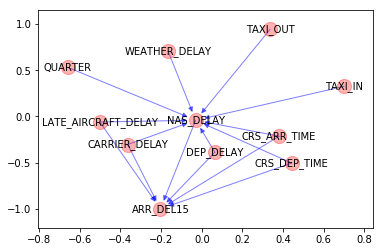

In [14]:
draw_graph(flight_edges_df, 'nas-arr_del15.png')

### Late Aircraft Delay

Now, we took a look at the variables that LATE_AIRCRAFT_DELAY rely on. From this point on, we will not display the graph.

In [15]:
late_aircraft_from = ['MONTH','DEP_DELAY','CARRIER_DELAY','WEATHER_DELAY','NAS_DELAY']
regression_model(late_aircraft_from, 'LATE_AIRCRAFT_DELAY').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     LATE_AIRCRAFT_DELAY   R-squared:                       0.767
Model:                             OLS   Adj. R-squared:                  0.765
Method:                  Least Squares   F-statistic:                     505.2
Date:                 Sun, 08 Apr 2018   Prob (F-statistic):          4.11e-240
Time:                         03:49:15   Log-Likelihood:                -2974.1
No. Observations:                  774   AIC:                             5958.
Df Residuals:                      769   BIC:                             5981.
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
MONTH             0.2798      0.058      4.816      0.000       0.166       0.394
DEP_DELAY         0.6290      0.013     47.060      0.000       0.603       0.655
CARRIER_DELAY    -0.6316      0.018    -34.622      0.000      -0.667      -0.596
WEATHER_DELAY    -0.6415      0.069     -9.292      0.000      -0.777      -0.506
NAS_DELAY        -0.2710      0.021    -12.961      0.000      -0.312      -0.230
==============================================================================
Omnibus:                      221.756   Durbin-Watson:                   2.044
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7118.959
Skew:                          -0.605   Prob(JB):                         0.00
Kurtosis:                      17.808   Cond. No.                         10.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
flight_edges_df, bn = update_flights_edges_df(late_aircraft_from, 'LATE_AIRCRAFT_DELAY',flight_edges_df)

[('NAS_DELAY', 'LATE_AIRCRAFT_DELAY'), ('LATE_AIRCRAFT_DELAY', 'NAS_DELAY')]


Since __NAS_DELAY__ and __LATE_AIRCRAFT_DELAY__ have edges pointing to each other, we must decide which edge we are going to get rid of. The FAA (http://aspmhelp.faa.gov/index.php/Types_of_Delay) defines __NAS_DELAY__ as delay that is "within the control of the National Airspace System (NAS)," including "non-extreme weather conditions, airport operations, heavy traffic volume, air traffic control, etc." It goes on to state that delays at the destination airport that occur after Actual Gate Out time are attributed to the NAS (such as gate in delay and taxi in delay). On the other hand, FAA defines __LATE_AIRCRAFT_DELAY__ as arrival delay due to the ripple effect of an earlier delay at downstream airports is referred to as delay propagation. That is, the two seem to have no direct relationship with one another at all. Therefore, we remove both edges.

In [17]:
# remove both edges
flight_edges_df, _ = remove_edge('NAS_DELAY','LATE_AIRCRAFT_DELAY', flight_edges_df)
flight_edges_df, bn = remove_edge('LATE_AIRCRAFT_DELAY','NAS_DELAY', flight_edges_df)

No cycle found! You may proceed.
No cycle found! You may proceed.


### Carrier Delay

In [18]:
carrier_delay_from = ['CRS_DEP_TIME','DEP_DELAY','TAXI_OUT','TAXI_IN','CRS_ARR_TIME','WEATHER_DELAY','NAS_DELAY','LATE_AIRCRAFT_DELAY']
regression_model(carrier_delay_from, 'CARRIER_DELAY').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          CARRIER_DELAY   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     718.8
Date:                Sun, 08 Apr 2018   Prob (F-statistic):               0.00
Time:                        03:49:15   Log-Likelihood:                -3056.7
No. Observations:                 774   AIC:                             6129.
Df Residuals:                     766   BIC:                             6167.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
CRS_DEP_TIME          -11.3102      1.201     -9.416      0.000     -13.668      -8.952
DEP_DELAY               0.8709      0.012     73.287      0.000       0.848       0.894
TAXI_OUT                0.4104      0.038     10.803      0.000       0.336       0.485
TAXI_IN                 0.4520      0.055      8.285      0.000       0.345       0.559
CRS_ARR_TIME          -12.0200      1.187    -10.130      0.000     -14.349      -9.691
WEATHER_DELAY          -0.8551      0.077    -11.177      0.000      -1.005      -0.705
NAS_DELAY              -0.5414      0.027    -20.400      0.000      -0.594      -0.489
LATE_AIRCRAFT_DELAY    -0.9851      0.025    -38.862      0.000      -1.035      -0.935
==============================================================================
Omnibus:                      192.514   Durbin-Watson:                   2.029
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7922.060
Skew:                          -0.240   Prob(JB):                         0.00
Kurtosis:                      18.666   Cond. No.                         194.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
flight_edges_df, bn = update_flights_edges_df(carrier_delay_from, 'CARRIER_DELAY',flight_edges_df)

[('NAS_DELAY', 'CARRIER_DELAY'), ('CARRIER_DELAY', 'NAS_DELAY')]


__CARRIER_DELAY__ is within the control of the air carrier, such as: aircraft cleaning, aircraft damage, awaiting the arrival of connecting passengers or crew, baggage, bird strike, cargo loading, catering, computer, outage-carrier equipment, crew legality (pilot or attendant rest), damage by hazardous goods, engineering inspection, fueling, handling disabled passengers, late crew, lavatory servicing, maintenance, oversales, potable water servicing, removal of unruly passenger, slow boarding or seating, stowing carry-on baggage, weight and balance delays. This seems to have little to do with __NAS_DELAY__ and vice versa. Thus, we remove both edges

In [20]:
# remove both edges
flight_edges_df, _ = remove_edge('CARRIER_DELAY','NAS_DELAY', flight_edges_df)
flight_edges_df, bn = remove_edge('NAS_DELAY','CARRIER_DELAY', flight_edges_df)

[('CARRIER_DELAY', 'LATE_AIRCRAFT_DELAY'), ('LATE_AIRCRAFT_DELAY', 'CARRIER_DELAY')]
[('CARRIER_DELAY', 'LATE_AIRCRAFT_DELAY'), ('LATE_AIRCRAFT_DELAY', 'CARRIER_DELAY')]


Recall that FAA defines __LATE_AIRCRAFT_DELAY__ as arrival delay due to the ripple effect of an earlier delay at downstream airports is referred to as delay propagation. It would seem probable that a late prior aircraft could cause carrier delay but not the other way around. Thus, we only remove the edge from CARRIER_DELAY to LATE_AIRCRAFT_DELAY.

In [21]:
flight_edges_df, bn = remove_edge('CARRIER_DELAY','LATE_AIRCRAFT_DELAY', flight_edges_df)

No cycle found! You may proceed.


### WEATHER_DELAY

Though not ideal in p-value, CRS_DEP_TIME seems like the only likely variable which WEATHER_DELAY may be dependent on.

In [22]:
weather_delay_from = ['CRS_DEP_TIME']
regression_model(weather_delay_from, 'WEATHER_DELAY').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          WEATHER_DELAY   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     2.564
Date:                Sun, 08 Apr 2018   Prob (F-statistic):              0.110
Time:                        03:49:15   Log-Likelihood:                -2484.5
No. Observations:                 774   AIC:                             4971.
Df Residuals:                     773   BIC:                             4976.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
CRS_DEP_TIME     0.5305      0.331      1.601      0.110      -0.120       1.181
==============================================================================
Omnibus:                     2032.196   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         18957026.547
Skew:                          27.651   Prob(JB):                         0.00
Kurtosis:                     767.694   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
flight_edges_df, bn = update_flights_edges_df(weather_delay_from, 'WEATHER_DELAY',flight_edges_df)

No cycle found! You may proceed.


### Calendar Quarter

We come to a rather interesting (not entirely unlikely) conclusion that CRS_DEP_TIME and CRS_ARR_TIME may directly influence QUARTER.

In [24]:
quarter_from = ['MONTH','CRS_DEP_TIME','CRS_ARR_TIME']
regression_model(quarter_from, 'QUARTER').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                QUARTER   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                 2.549e+04
Date:                Sun, 08 Apr 2018   Prob (F-statistic):               0.00
Time:                        03:49:15   Log-Likelihood:                -138.60
No. Observations:                 774   AIC:                             283.2
Df Residuals:                     771   BIC:                             297.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
MONTH            0.3317      0.003    120.077      0.000       0.326       0.337
CRS_DEP_TIME     0.2701      0.024     11.410      0.000       0.224       0.317
CRS_ARR_TIME     0.3320      0.022     15.264      0.000       0.289       0.375
==============================================================================
Omnibus:                      485.051   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               45.454
Skew:                           0.036   Prob(JB):                     1.35e-10
Kurtosis:                       1.815   Cond. No.                         21.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [25]:
flight_edges_df, bn = update_flights_edges_df(quarter_from, 'QUARTER',flight_edges_df)

No cycle found! You may proceed.


### Departure Delay

This is the difference in minutes between scheduled and actual departure time. Early departures show negative numbers.

In [26]:
departure_delay_from = ['QUARTER','MONTH','DAY_OF_WEEK','CRS_DEP_TIME','TAXI_OUT','TAXI_IN','CRS_ARR_TIME','CARRIER_DELAY','WEATHER_DELAY','NAS_DELAY','LATE_AIRCRAFT_DELAY']
regression_model(departure_delay_from, 'DEP_DELAY').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              DEP_DELAY   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                     1107.
Date:                Sun, 08 Apr 2018   Prob (F-statistic):               0.00
Time:                        03:49:15   Log-Likelihood:                -3080.4
No. Observations:                 774   AIC:                             6183.
Df Residuals:                     763   BIC:                             6234.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
QUARTER                 9.2545      1.654      5.596      0.000       6.008      12.501
MONTH                  -2.6441      0.554     -4.769      0.000      -3.732      -1.556
DAY_OF_WEEK             0.8831      0.222      3.981      0.000       0.448       1.319
CRS_DEP_TIME            9.4570      1.378      6.864      0.000       6.752      12.162
TAXI_OUT               -0.6122      0.042    -14.439      0.000      -0.695      -0.529
TAXI_IN                -0.5921      0.057    -10.305      0.000      -0.705      -0.479
CRS_ARR_TIME           10.2453      1.373      7.459      0.000       7.549      12.942
CARRIER_DELAY           1.0027      0.013     75.916      0.000       0.977       1.029
WEATHER_DELAY           0.9887      0.078     12.618      0.000       0.835       1.142
NAS_DELAY               0.6361      0.027     23.631      0.000       0.583       0.689
LATE_AIRCRAFT_DELAY     1.1374      0.022     52.286      0.000       1.095       1.180
==============================================================================
Omnibus:                      277.929   Durbin-Watson:                   2.091
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2380.494
Skew:                           1.375   Prob(JB):                         0.00
Kurtosis:                      11.140   Cond. No.                         167.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
flight_edges_df, bn = update_flights_edges_df(departure_delay_from,'DEP_DELAY',flight_edges_df)

[('NAS_DELAY', 'DEP_DELAY'), ('DEP_DELAY', 'NAS_DELAY')]


It is not very likely that an NAS-related delay causes a security-related delay. Therefore, we will remove the edge from NAS_DELAY to SECURITY_DELAY.

In [28]:
flight_edges_df, bn = remove_edge('NAS_DELAY','SECURITY_DELAY', flight_edges_df)

[('NAS_DELAY', 'DEP_DELAY'), ('DEP_DELAY', 'NAS_DELAY')]


Departure time is the time recorded when the plane's parking brakes are released, which is after doors are closed and just prior to the plane beginning to taxi. That is, departure time starts right before a plan leaves its gate. Therefore, while it is likely that a difference in CRS departure time and actual departure time causes an NAS delay, it is impossible for NAS delay to influence the departure time difference. Thus, we remove the edge from NAS_DELAY to DEP_DELAY.

In [29]:
flight_edges_df, bn = remove_edge('NAS_DELAY','DEP_DELAY', flight_edges_df)

[('CARRIER_DELAY', 'DEP_DELAY'), ('DEP_DELAY', 'LATE_AIRCRAFT_DELAY'), ('LATE_AIRCRAFT_DELAY', 'CARRIER_DELAY')]


Departure delay cannot lead to a late aircraft delay: this is temporally impossible, so we get rid of that directed edge.

In [30]:
flight_edges_df, bn = remove_edge('DEP_DELAY', 'LATE_AIRCRAFT_DELAY', flight_edges_df)

[('CARRIER_DELAY', 'DEP_DELAY'), ('DEP_DELAY', 'CARRIER_DELAY')]


Again, temporally, departure delay cannot lead to a carrier delay. Therefore, we remove that directed edge.

In [31]:
flight_edges_df, bn = remove_edge('DEP_DELAY', 'CARRIER_DELAY', flight_edges_df)

No cycle found! You may proceed.


By the same reasoning as above, we remove the edge from DEP_DELAY to SECURITY_DELAY.

In [32]:
flight_edges_df, bn = remove_edge('DEP_DELAY', 'SECURITY_DELAY', flight_edges_df)

No cycle found! You may proceed.


### Taxi Out

Taxi Out Time, in Minutes.

In [33]:
taxi_out_from = ['QUARTER','CRS_DEP_TIME','DEP_DELAY','TAXI_IN','CRS_ARR_TIME','CARRIER_DELAY','WEATHER_DELAY','NAS_DELAY','LATE_AIRCRAFT_DELAY']
regression_model(taxi_out_from, 'TAXI_OUT').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               TAXI_OUT   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     704.4
Date:                Sun, 08 Apr 2018   Prob (F-statistic):               0.00
Time:                        03:49:15   Log-Likelihood:                -2878.1
No. Observations:                 774   AIC:                             5774.
Df Residuals:                     765   BIC:                             5816.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
QUARTER                 3.9395      0.287     13.709      0.000       3.375       4.504
CRS_DEP_TIME           15.5501      0.894     17.388      0.000      13.795      17.306
DEP_DELAY              -0.3320      0.024    -13.650      0.000      -0.380      -0.284
TAXI_IN                -0.2659      0.046     -5.809      0.000      -0.356      -0.176
CRS_ARR_TIME           16.4522      0.864     19.032      0.000      14.755      18.149
CARRIER_DELAY           0.3170      0.027     11.856      0.000       0.265       0.370
WEATHER_DELAY           0.2676      0.065      4.124      0.000       0.140       0.395
NAS_DELAY               0.4101      0.023     18.162      0.000       0.366       0.454
LATE_AIRCRAFT_DELAY     0.3247      0.033      9.823      0.000       0.260       0.390
==============================================================================
Omnibus:                       30.221   Durbin-Watson:                   1.833
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               45.242
Skew:                           0.337   Prob(JB):                     1.50e-10
Kurtosis:                       3.974   Cond. No.                         199.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [34]:
flight_edges_df, bn = update_flights_edges_df(taxi_out_from,'TAXI_OUT',flight_edges_df)

[('NAS_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'NAS_DELAY')]


In [35]:
flight_edges_df, bn = remove_edge('TAXI_OUT', 'NAS_DELAY', flight_edges_df)

[('NAS_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'CARRIER_DELAY'), ('CARRIER_DELAY', 'DEP_DELAY'), ('DEP_DELAY', 'NAS_DELAY')]


In [36]:
flight_edges_df, bn = remove_edge('TAXI_OUT', 'CARRIER_DELAY', flight_edges_df)

[('NAS_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'DEP_DELAY'), ('DEP_DELAY', 'NAS_DELAY')]


In [37]:
flight_edges_df, bn = remove_edge('TAXI_OUT', 'SECURITY_DELAY', flight_edges_df)

[('NAS_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'DEP_DELAY'), ('DEP_DELAY', 'NAS_DELAY')]


In [38]:
flight_edges_df, bn = remove_edge('DEP_DELAY', 'NAS_DELAY', flight_edges_df)

[('TAXI_OUT', 'DEP_DELAY'), ('DEP_DELAY', 'TAXI_OUT')]


In [39]:
flight_edges_df, bn = remove_edge('DEP_DELAY', 'TAXI_OUT', flight_edges_df)

No cycle found! You may proceed.


### Taxi In

In [40]:
taxi_in_from = ['QUARTER','CRS_DEP_TIME','DEP_DELAY','TAXI_OUT','CRS_ARR_TIME','CARRIER_DELAY','WEATHER_DELAY','NAS_DELAY','LATE_AIRCRAFT_DELAY']
regression_model(taxi_in_from, 'TAXI_IN').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                TAXI_IN   R-squared:                       0.566
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     110.7
Date:                Sun, 08 Apr 2018   Prob (F-statistic):          4.22e-132
Time:                        03:49:15   Log-Likelihood:                -2678.8
No. Observations:                 774   AIC:                             5376.
Df Residuals:                     765   BIC:                             5417.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
QUARTER                 1.7423      0.240      7.266      0.000       1.272       2.213
CRS_DEP_TIME            4.8136      0.798      6.033      0.000       3.247       6.380
DEP_DELAY              -0.1926      0.020     -9.739      0.000      -0.231      -0.154
TAXI_OUT               -0.1589      0.027     -5.809      0.000      -0.213      -0.105
CRS_ARR_TIME            5.8182      0.783      7.427      0.000       4.280       7.356
CARRIER_DELAY           0.1961      0.021      9.185      0.000       0.154       0.238
WEATHER_DELAY           0.1814      0.050      3.609      0.000       0.083       0.280
NAS_DELAY               0.2577      0.019     13.786      0.000       0.221       0.294
LATE_AIRCRAFT_DELAY     0.2341      0.026      9.083      0.000       0.183       0.285
==============================================================================
Omnibus:                     1114.261   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           480919.698
Skew:                           7.674   Prob(JB):                         0.00
Kurtosis:                     124.147   Cond. No.                         237.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [41]:
flight_edges_df, bn = update_flights_edges_df(taxi_in_from,'TAXI_IN',flight_edges_df)

[('NAS_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'DEP_DELAY'), ('DEP_DELAY', 'TAXI_IN'), ('TAXI_IN', 'NAS_DELAY')]


In [42]:
flight_edges_df, bn = remove_edge('TAXI_OUT','DEP_DELAY', flight_edges_df)

[('NAS_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'TAXI_IN'), ('TAXI_IN', 'NAS_DELAY')]


In [43]:
flight_edges_df, bn = remove_edge('TAXI_IN','NAS_DELAY', flight_edges_df)

[('TAXI_IN', 'CARRIER_DELAY'), ('CARRIER_DELAY', 'DEP_DELAY'), ('DEP_DELAY', 'TAXI_IN')]


In [44]:
flight_edges_df, bn = remove_edge('TAXI_IN','CARRIER_DELAY', flight_edges_df)

[('TAXI_IN', 'DEP_DELAY'), ('DEP_DELAY', 'TAXI_IN')]


In [45]:
flight_edges_df, bn = remove_edge('TAXI_IN','DEP_DELAY', flight_edges_df)

[('TAXI_OUT', 'TAXI_IN'), ('TAXI_IN', 'TAXI_OUT')]


In [46]:
flight_edges_df, bn = remove_edge('TAXI_IN','TAXI_OUT', flight_edges_df)

No cycle found! You may proceed.


### DelayedDepartureSFO

In [47]:
delayed_SFO_from = ['WEATHER_DELAY','ScheduledDepartureSFO','DelayedArrivalPHL','ScheduledArrivalPHL']
regression_model(delayed_SFO_from, 'DelayedDepartureSFO').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     DelayedDepartureSFO   R-squared:                       0.705
Model:                             OLS   Adj. R-squared:                  0.703
Method:                  Least Squares   F-statistic:                     459.0
Date:                 Sun, 08 Apr 2018   Prob (F-statistic):          3.94e-202
Time:                         03:49:15   Log-Likelihood:                -1650.4
No. Observations:                  774   AIC:                             3309.
Df Residuals:                      770   BIC:                             3327.
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
WEATHER_DELAY             0.0310      0.013      2.461      0.014       0.006       0.056
ScheduledDepartureSFO     0.1320      0.004     29.637      0.000       0.123       0.141
DelayedArrivalPHL         0.3840      0.045      8.468      0.000       0.295       0.473
ScheduledArrivalPHL      -0.0305      0.013     -2.282      0.023      -0.057      -0.004
==============================================================================
Omnibus:                      271.130   Durbin-Watson:                   2.152
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1322.890
Skew:                           1.528   Prob(JB):                    5.47e-288
Kurtosis:                       8.629   Cond. No.                         13.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [48]:
flight_edges_df, bn = update_flights_edges_df(delayed_SFO_from,'DelayedDepartureSFO',flight_edges_df)

No cycle found! You may proceed.


###   DelayedArrivalPHL

In [49]:
delayed_PHL_from = ['CRS_DEP_TIME','WEATHER_DELAY','DelayedDepartureSFO','ScheduledDepartureSFO','ScheduledArrivalPHL']
regression_model(delayed_PHL_from, 'DelayedArrivalPHL').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      DelayedArrivalPHL   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     586.8
Date:                Sun, 08 Apr 2018   Prob (F-statistic):          1.38e-259
Time:                        03:49:15   Log-Likelihood:                -1438.2
No. Observations:                 774   AIC:                             2886.
Df Residuals:                     769   BIC:                             2910.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
CRS_DEP_TIME             -0.0057      0.094     -0.060      0.952      -0.190       0.179
WEATHER_DELAY             0.0506      0.009      5.351      0.000       0.032       0.069
DelayedDepartureSFO       0.2219      0.026      8.463      0.000       0.170       0.273
ScheduledDepartureSFO    -0.0412      0.005     -8.628      0.000      -0.051      -0.032
ScheduledArrivalPHL       0.2355      0.006     40.593      0.000       0.224       0.247
==============================================================================
Omnibus:                      512.503   Durbin-Watson:                   1.907
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8843.408
Skew:                           2.723   Prob(JB):                         0.00
Kurtosis:                      18.638   Cond. No.                         36.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [50]:
flight_edges_df, bn = update_flights_edges_df(delayed_PHL_from,'DelayedArrivalPHL',flight_edges_df)

[('DelayedDepartureSFO', 'DelayedArrivalPHL'), ('DelayedArrivalPHL', 'DelayedDepartureSFO')]


In [51]:
flight_edges_df, bn = remove_edge('DelayedArrivalPHL','DelayedDepartureSFO', flight_edges_df)

No cycle found! You may proceed.


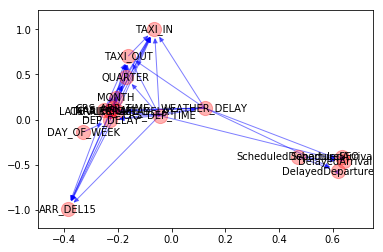

In [52]:
draw_graph(flight_edges_df,'final_bn.png')

In [53]:
print('This graph is a DAG :', nx.is_directed_acyclic_graph(bn),'\nThis edge is a tree :', nx.is_tree(bn))

This graph is a DAG : True 
This edge is a tree : False


In [54]:
# nodes
nodes_li = list(set(list(flight_edges_df['from_node'])+list(flight_edges_df['to_node'])))
nodes_df = pd.DataFrame(nodes_li)
nodes_df.columns = ['nodes']
flight_edges_df.columns=['Source','Target']
# save as csv
flight_edges_df.to_csv('edges.csv',index=False)
nodes_df.to_csv('nodes.csv',index=False)
# numbers to print
print('There are', nodes_df.shape[0], 'nodes and', flight_edges_df.shape[0], 'edges in this graph.')

There are 17 nodes and 52 edges in this graph.
